In [2]:
import numpy as np
import pandas as pd

import string
import random
import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

In [3]:
!pip install tslearn >> None

# Анализируем car_info

In [ ]:
car_info = pd.read_csv('../data/car_info.csv')
print(car_info.shape)
car_info.hist(figsize=(20, 20))
car_info.sample(2)

# Анализируем rider_info

In [6]:
rider_info = pd.read_csv('../data/rider_info.csv')
rider_info.hist()
rider_info.sample(2)

# Анализируем fix_info

In [7]:
fix_info = pd.read_csv('../data/fix_info.csv')
print(fix_info.shape)
fix_info.hist()
fix_info.sample(2)

# Анализируем rides_info

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,car_rating,user_ride_quality,deviation_normal,target_1,target_2,real_slope,killer_fs
798804,x17294225B,t76126090D,O1c,2020-03-12 14:23:24.633560704,5.488101,5.260460,5.186037,31.040767,49.00000,0,0.696274,0,1.5,-4.618123,11.568383,9,engine_ignition,-0.17,136
327349,h26595627L,S89208487G,E1n,2020-02-24 03:49:26.031295590,4.874791,4.297974,5.764795,43.210880,44.21088,0,0.596734,0,3.9,-2.223376,4.079060,25,engine_fuel,-0.15,132
832003,Z66263143H,v25172188Y,S1t,2020-01-22 12:21:08.881409868,4.634979,5.482547,5.025050,34.000000,48.00000,1,0.539676,0,1.2,-0.573190,-4.100051,26,break_bug,-0.15,84
804382,F60834453v,u12966392l,T1b,2020-03-11 15:20:16.669351855,3.475545,5.994535,4.329686,36.000000,33.00000,2,0.674346,0,1.1,-4.785005,-2.509644,12,engine_overheat,-0.17,127
631288,s12580313y,k19286418k,s1v,2020-01-15 05:27:32.277835864,3.544849,4.916010,4.062836,45.484173,45.00000,0,0.596746,0,1.5,0.261183,8.762065,16,electro_bug,-0.00,99


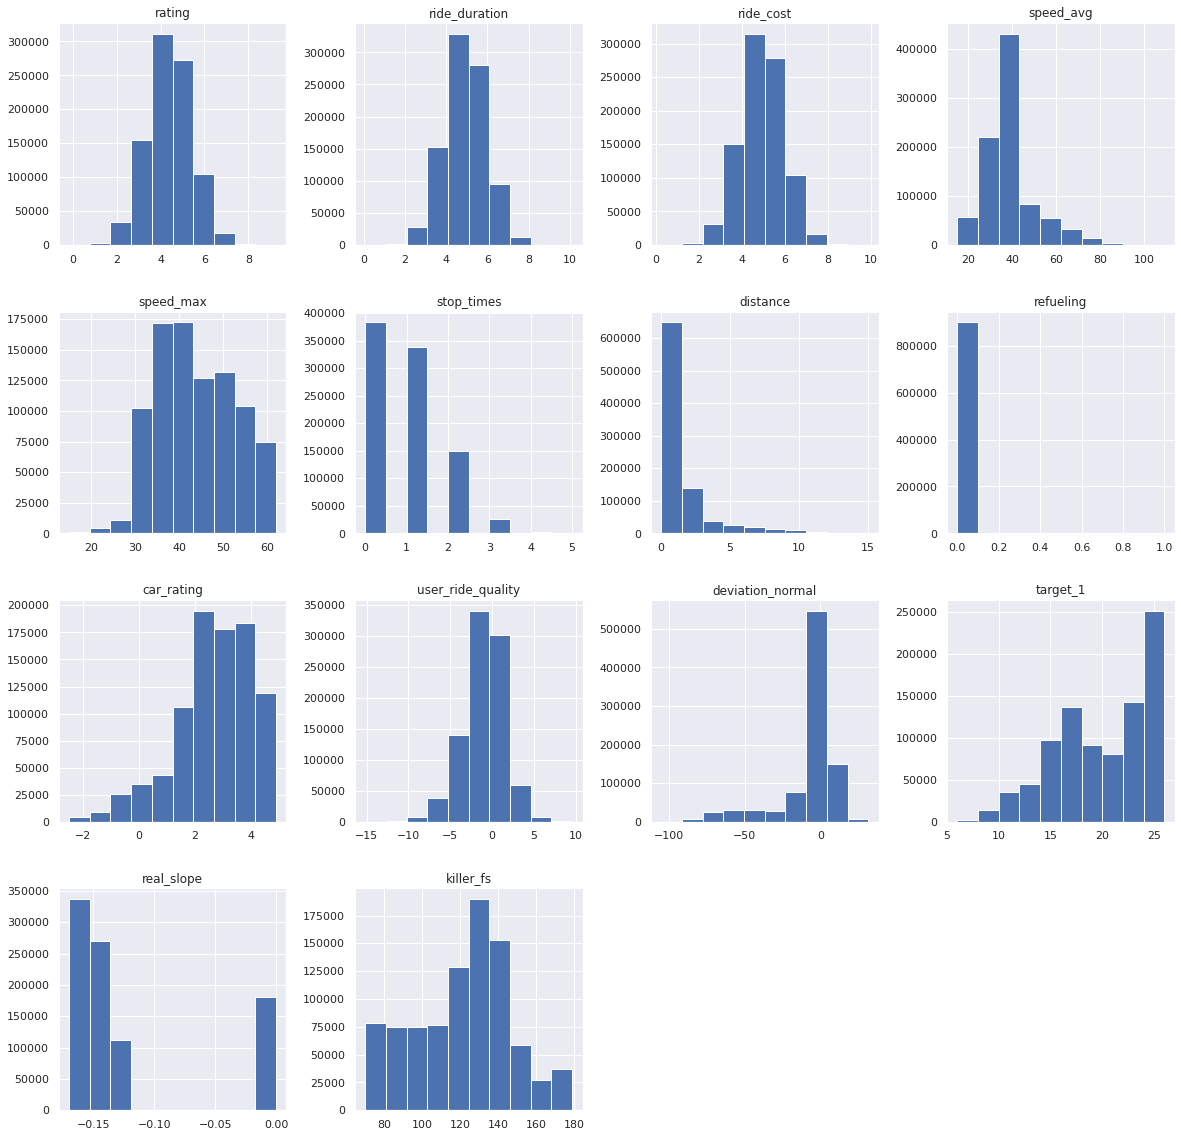

In [13]:
rides_info = pd.read_csv('../data/rides_info.csv')
print(rides_info.shape)
rides_info.hist(figsize=(20, 20))
rides_info.sample(2)

In [ ]:
# cols = ['ride_duration', 'distance', 'speed_max', 'speed_avg', 'target_2', 'stop_times', 'rating', 'car_rating', 'killer_fs']
# sns.pairplot(data = rides_info[cols], hue = 'target_2', corner=True);

# Добавляем сгенерированные фичи и далее от них генерируем таргет

In [ ]:
# Добавляем признаки из информации про поездки

q_right = lambda x : sum(x > 120)/len(x)
f_low_r = lambda x : sum(x < 2.0)

rides_info['real_slope'] = abs(rides_info['real_slope'])

rides_info_gr = rides_info.groupby('car_id', as_index=False).agg(
    ride_duration_sum = ('ride_duration', 'sum'),
    ride_distance_sum = ('distance', 'sum'),
    speed_avg_mean = ('speed_avg', 'mean'),
    speed_max_mean = ('speed_max', 'mean'),
    speed_max_q = ('speed_max', q_right),
    speed_max_max = ('speed_max', 'max'),
    crit_low_r = ('rating', f_low_r),
    killer_fs = ('killer_fs', 'max'),
    real_slope = ('real_slope', 'max'),
)


In [ ]:
# (rides_info['real_slope'].value_counts().index - rides_info['real_slope'].min()) /  rides_info['real_slope'].max()
rides_info_gr['real_slope'].value_counts(dropna=False)

In [ ]:
fix_info['worker_experience'] = fix_info.groupby('worker_id', as_index=False)['car_id'].transform('count')

fix_info.hist(figsize = (15, 10))
fix_info.head()

In [ ]:
# Добавляем признаки из информации про ремонт

f_nuniq = lambda x : len(np.unique(x))
f_crit_perc_q = lambda x : sum(x >= 7.5)/len(x)
f_crit_q = lambda x : sum(x > 8.0)

avg_exp = fix_info['worker_experience'].median()
f_low_exp = lambda x: sum(x <= avg_exp*0.5)

fix_info_gr = fix_info.groupby('car_id', as_index=False).agg(
    worker_count = ('worker_id', 'count'),
    destroy_degree_max = ('destroy_degree', 'max'),
    destroy_degree_sum = ('destroy_degree', 'sum'),
    work_duration_mean = ('work_duration', 'mean'),
    work_duration_max = ('work_duration', 'max'),
    work_type_nuniq = ('work_type', f_nuniq),
    work_type_crit_perc_q = ('destroy_degree', f_crit_perc_q),
    work_type_crit_q = ('destroy_degree', f_crit_q),
    worker_experience_mean = ('worker_experience', 'mean'),
    worker_low_exp = ('worker_experience', f_low_exp),
)
fix_info_gr.hist(figsize = (15, 10))
fix_info_gr.sample(5)

In [ ]:
# Добавляем признаки временные из информации про поездки с помощью TSfresh

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
import tsfresh

In [ ]:
from tsfresh.feature_extraction import settings

settings_efficient = {}

# settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
# settings_efficient.update(settings.IndexBasedFCParameters())
# settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient.update(settings.EfficientFCParameters())

# settings_efficient

In [ ]:
# rides_info.car_id.value_counts() #.head(3)

rides_info['deviation_normal'].isnull().sum()

In [ ]:
settings = settings_efficient

# train_df.fillna(0, inplace=True)
res_train_df = None
# res_test_df = None

numeric_cols = ['deviation_normal']
# vr = VarianceThreshold(0.5)
for num, num_col in enumerate(numeric_cols):
    now = datetime.now()
    print(num, 'col', num_col)
    
#     settings = full_settings_filtered[num_col]
    
    Distributor = MultiprocessingDistributor(n_workers=4,
                                             disable_progressbar=False,
                                             progressbar_title="Feature Extraction")

    X = extract_features(rides_info[["car_id", "ride_date", num_col]].fillna(0), 
#                                   y,
                                  column_id='car_id',
                                  column_sort='ride_date',
                                  n_jobs=1,
#                                   chunksize=5,
                                  default_fc_parameters=settings_efficient#settings,
#                                   fdr_level = 0.01,
#                                   distributor = Distributor
                        )
    
#     X = pd.DataFrame(vr.fit_transform(X), columns=X.columns[vr.get_support()])
    print('прошло времени после генерации', datetime.now() - now)
        
    if res_train_df is None:
        res_train_df = X
#         res_train_df["target"] = rides_info['target_2']
        res_train_df["car_id"] = rides_info['car_id'].unique()
    else:
        X = reduce_mem_usage(X)
        res_train_df = pd.concat([res_train_df, X], axis=1)
#         res_train_df.to_csv("./../tmp_data/del_full_train_tsfresh.csv", index=False)        
        print('прошло времени до сохраниения', datetime.now() - now)


In [ ]:
# tmp = rides_info.merge(res_train_df[['car_id'] + ['deviation_normal__linear_trend__attr_"slope"']], on = 'car_id', how = 'left')
# tmp['slope_sign'] = tmp['deviation_normal__linear_trend__attr_"slope"'] > 0
# rides_info#['slope'] = 

# tmp[['real_slope', 'slope_sign']].corr()

rides_info_gr.columns

In [ ]:
print(car_info['car_id'].nunique())
car_info_fs = pd.merge(car_info, rides_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique())
car_info_fs = pd.merge(car_info_fs, fix_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique())
car_info_fs = pd.merge(car_info_fs, res_train_df, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique())

# Отнормируем фичи, чтоб легче было слепить из них таргет

In [ ]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

to_scale_fs = ['car_rating', 'year_to_start', 'riders', 'ride_duration_sum', 'speed_avg_mean',
               'ride_distance_sum', 
               'speed_max_mean', 'speed_max_q', 'speed_max_max', 'crit_low_r', 'worker_count',
               'destroy_degree_max', 'destroy_degree_sum', 'work_duration_mean', 'work_duration_max',
               'work_type_nuniq', 'work_type_crit_perc_q', 'work_type_crit_q', 'worker_experience_mean',
               
               'real_slope', 'deviation_normal__linear_trend__attr_"slope"', 'killer_fs']

not_to_scale_fs = [c for c in car_info_fs.columns if c not in to_scale_fs]

mapper = DataFrameMapper([(to_scale_fs, MinMaxScaler())])
scaled_features = mapper.fit_transform(car_info_fs.copy(), 4)
car_info_fs_ = pd.DataFrame(scaled_features,
                            index = car_info_fs.index,
                            columns = to_scale_fs)

car_info_fs = pd.concat([car_info_fs_, car_info_fs[not_to_scale_fs]], axis=1)
car_info_fs.sample(5)

In [ ]:
car_info_fs['target_2'].value_counts()

In [ ]:
# car_info_fs['real_slope'].value_counts(dropna=False)
# TODO не все машины есть в трейне!

In [ ]:
def get_base_time_accident(x):
    
    # Фичи из rides_info
    
    ride_duration_sum = x.ride_duration_sum
    speed_avg_mean = x.speed_avg_mean
    speed_max_mean = x.speed_max_mean
    speed_max_q = x.speed_max_q
    speed_max_max = x.speed_max_max
    crit_low_r = x.crit_low_r
    
    # Фичи из car_info
    riders = x.riders
    
    # Фичи из fix_info 
    
    worker_count = x.worker_count
    destroy_degree_max = x.destroy_degree_max
    destroy_degree_sum = x.destroy_degree_sum
    work_duration_mean = x.work_duration_mean
    work_duration_max = x.work_duration_max
    
    work_type_nuniq = x.work_type_nuniq
    work_type_crit_perc_q = x.work_type_crit_perc_q
    work_type_crit_q = x.work_type_crit_q
    worker_low_exp = x.worker_low_exp
    
    worker_experience_mean = x.worker_experience_mean
    main_city = x.main_city
    
    # base_time_positive = work_type_crit_q + work_type_crit_perc_q + destroy_degree_max + work_type_nuniq
    # base_time_negative = worker_experience_mean
    
    # Поездки / пробег / разрушения 
    A = (2 - x.riders)*(2 - x.ride_distance_sum)*(2 - (x.destroy_degree_sum)**2)*(2 - x.destroy_degree_max)
    
    # Средний опыт рабочих / Число слабых рабочих / Рабочий осмотр
    B = (1 + (x.worker_experience_mean)**2)*(2 - x.worker_low_exp)*(1 + x.work_duration_mean)*(2 - x.destroy_degree_max)*(2 - x.work_type_crit_q) # Перепроверить
    
    # Тренд взависимости от Таргета
    C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
    
    D = (1 + x.killer_fs)
    
    base_time_positive = A*B*C*D
    
    return base_time_positive
    

In [ ]:
# TODO

# - Добавить связь модель машины - таргет, чтоб кат фичи были важны
# - Добить генерацию численного таргета
# - Добавить связь - User_id-Car_id
# - Отвалидировать рост точности исходя из добавления фичей
# - Добавить третий ранжирующий таргет по порядку позиций поломок

* engine_check
Индикатор «Чек двигателя» -  Этот индикатор на приборке загорается, когда ЭБУ (электронный блок управления двигателем) 
обнаруживает в системе код ошибки в работе какой-либо системы. Например, это происходит, когда ошибку выдает датчик.

* engine_overheat
Перегрев двигателя - Наиболее частой причиной перегрева двигателя является утечка охлаждающей жидкости.
Например, чаще утечка антифриза связана с разгерметизацией радиатора охлаждения, поломкой водяной помпы или с повреждением расширительного бачка. Чтобы уменьшить риск перегрева мотора, нужно заранее менять радиатор и помпу. 

* engine_ignition
Пропуск зажигания — это явление, при котором по какой-то причине воспламенение не произошло, 
Машина ускоряется неровно, набор скорости ей дается тяжело. Неровный холостой ход. Вы можете почувствовать, что машина вибрирует. 
Дело в том, двигатель работает не сбалансированно из-за одного или нескольких неработающих цилиндров

* engine_fuel
Большой расход топлива - Когда двигатель работает эффективно, он сжигает топливо со скоростью, которая помогает эффективно 
расходовать топливо (экономия топлива). Однако некоторые детали топливной системы, такие как топливные фильтры, воздушные фильтры,
датчик массового расхода воздуха и кислородные датчики (лямба-зонд), со временем загрязняются и изнашиваются.

* electro_bug
Разряженный аккумулятор - Срок службы автомобильных аккумуляторов в среднем составляет 3-4 года, или 80 000-100 000 км. 
Батарея обычно стареет со временем, как и любой аккумулятор в вашем смартфоне. Чем чаще батарея проходит циклы разрядки/зарядки, тем быстрее она теряет способность поддерживать нормальный уровень заряда и определенное количество ампер.

* break_bug
Скрип тормозов - тормозная система подвержена износу в течение определенного времени. Тормоза жизненно важны для безопасной остановки.
Поэтому когда вы замечаете какие-либо признаки проблем, такие как визг, скрип или если, например, педаль тормоза стала мягкой, 

* wheel_shake
Дрожание рулевого колеса - Многочисленные проблемы могут вызвать дрожание/дребезжание рулевого колеса во время вождения.
Если это происходит сразу после запуска двигателя и начала вождения, причиной дрожания руля могут быть подшипники колес или поврежденные компоненты подвески. Если это происходит на более высоких скоростях, обычно это говорит о проблеме с балансировкой колес. 

* gear_stick
Неисправность автоматической коробки передач - При правильном обслуживании автоматическая коробка передач может без проблем работать более 300 000 км.
Современная автоматическая трансмиссия представляет собой гидравлическую систему, состоящую из нескольких сальников, прокладок и линий, которые могут быть повреждены, забиты мусором или протекать.
В большинстве случаев используемые сегодня автоматические коробки  передач при правильной эксплуатации и своевременном обслуживании могут потребовать капитальный ремонт при пробеге не ранее 150.000 километров.


engine_check engine_overheat engine_ignition fuel electro_bug break_bug wheel gear_stick

* `target_1` - int
* `target_2` - int

In [ ]:
# car_info_fs.columns.tolist() #.riders.value_counts()

In [ ]:
def make_target(x):
    
    intersept = 100
    # Все таргеты зависят от числа поездок!!!!!!!!!!!!
    # Далее просто берем разные коэффициенты и снижаем время службы 
    target_2 = x.target_2
    base_time_positive = get_base_time_accident(x)
    
    if target_2 == 'engine_fuel': # Что-то классические
        # Временной изгиб и далее аномалии в расходе топлива.
        target_1 = 1000*base_time_positive + intersept

    elif target_2 == 'engine_check':
        target_1 = 1000*base_time_positive + intersept
        # Аномалии из-за агресивного вождения машиной.
        # Если в показательно ТО преломился, то до следующего перелома остается 15 дней
        pass
        
    elif target_2 == 'engine_overheat':
        target_1 = 1000*base_time_positive + intersept
        # Долго не проверяли машину. Время с последней проверки определенного ТО. 
        # Количество аномальных скоростей
        pass

    elif target_2 == 'engine_ignition':
        target_1 = 1000*base_time_positive + intersept
        # Связанно с часто плохим user_ride_quality. Зависимость не линейная
        # Если качество поедки в среднем держится низко, то машина в скором времени перестает заводиться

    elif target_2 == 'gear_stick':
        # Что-то, что приводит к частым остановкам
        # Часто низкое качество поездки. 
        # Число остановок выше среднего
        # Количество выбросов в ТО, если больше 25, то осталось 15 дней + качество поездки
        target_1 = 1200*base_time_positive + intersept
        
    elif target_2 == 'break_bug':
        target_1 = 1500*base_time_positive + intersept
        # Возможно после частых высоких средних скоростей
        # Качество вождание часто низкое. 
        # Проблемы с тормозом. Возможно ниже рейтинг. Возможно показатели хуже
        pass
    
    elif target_2 == 'electro_bug':
        target_1 = 1700*base_time_positive + intersept
        #  Количество поездок с нулевым расстоянием
        #  Колличество выбросов низких оценок увеличивается со временем
        pass
            
    elif target_2 == 'wheel_shake':
        target_1 = 1900*base_time_positive + intersept
        # Аномалии в движении машины. 
        # Качество вождения нормальное, но есть негативный тренд в ТО
        pass
        
    else:
        target_1 = 5000*base_time_positive + intersept
        
    return target_1
    
car_info_fs['target_1'] = car_info_fs.apply(make_target, axis=1)

car_info_fs.sample(5)

In [ ]:
# car_info_fs[car_info_fs['target_1'].isnull()]

# car_info_fs.hist(figsize = (15, 15));

#TODO среднее по 10 критическим поездкам

In [ ]:
print(car_info_fs['target_1'].isnull().sum())
car_info_fs['target_1'].hist(bins=30)

In [ ]:
# sns.pairplot(data = car_info_fs, corner=True, hue='target_2');

In [ ]:
# car_info_fs.columns

# car_info_fs['car_id'].value_counts().hist()

# car_info_fs[car_info_fs['car_id'] == 'F19793670T']
car_info_fs

In [ ]:
# car_info_fs.columns

In [ ]:
# !pip install catboost

In [ ]:
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import Pool, CatBoostClassifier, CatBoostRegressor 
import gc 

gc.collect()

# Разделяем фичи на группы (удаляем килер фичи)

In [ ]:
drop_features = ['car_id', 'target_1', 'target_2', 'real_slope']
targets = ['target_2']  # target_1
cat_features = ['car_type', 'fuel_type', 'main_city', 'model']

filtered_features = [i for i in car_info_fs.columns if (i not in targets and i not in drop_features)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
# print('filtered_features', filtered_features)
# print('num_features', num_features)
print('targets', targets)

for c in cat_features:
    car_info_fs[c] = car_info_fs[c].astype(str)

In [ ]:
!pip install iterative-stratification >> None 

In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def make_multi_target(df, target = 'target_2'):
    
    if target in df.columns:
    
        one_hot = pd.get_dummies(df[target])
        df = df.drop(target, axis = 1)
        df = df.join(one_hot)
    
    return df


def create_folds(data, num_splits=3, targets = [0, 1, 2, 4]):
    if num_splits > 1:
        data['kfold'] = -1
        X = data
        y = data[targets]
        mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

        for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
        
    return data

kfolds = 4

targets = car_info.target_2.unique()
# car_info_fs = make_multi_target(car_info_fs, target = 'target_2')
# car_info_fs = create_folds(car_info_fs, num_splits=kfolds, targets = targets)

# car_info_fs = (car_info_fs
      # .pipe(make_multi_target, target = 'target_2')
      # .pipe(create_folds, num_splits = kfolds, targets = targets)
     # )

car_info_fs.head()

In [ ]:
# car_info_fs.columns

In [ ]:
# filtered_features

In [ ]:
# targets_dict = {'nothing' : 0, 'soft_1' : 1, 'soft_2' : 2, 'critical' : 4}
# f_map = lambda x: targets_dict.get(x, x)
# car_info_fs['target_2'] = car_info_fs['target_2'].map(f_map)

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)


In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']
X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = car_info_fs[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(X):
        
    # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
    # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(iterations = 3000,
                          # loss_function = 'MultiLogloss',
                          custom_metric ='Precision',
                          loss_function='MultiClass',
                          # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds=80)# + kfold*10 )
    
    clfs.append(clf)

    # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 300, use_best_model = True, plot = False)
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
scores = []
for n, clf in enumerate(clfs):
    # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MultiClass'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore'), clfs, 0.20, top_n=70)


In [ ]:
!pip install catboost >> None
!pip uninstall opencv-python -y >> None 
!pip install opencv-python >> None

In [ ]:
# import catboost
# from catboost import *


import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

In [ ]:
shap.dependence_plot("RM", shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
from catboost.utils import get_confusion_matrix
import seaborn
# from sklearn.metrics import confusion_matrix


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
confusion_matrix = get_confusion_matrix(clf, train_dataset, thread_count=-1)

In [ ]:
df_cm = pd.DataFrame(confusion_matrix, index = car_info.target_2.unique(),
                  columns = car_info.target_2.unique())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('n_fold', n_splits)
clfs = []

targets = targets

X = car_info_fs[filtered_features].fillna(0)#.copy()
y = car_info_fs[['target_1']].fillna(car_info_fs['target_1'].mean())#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(X):
        
#     X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
#     y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
#     eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
    print(X_train.shape, y_train.shape)
    clf = CatBoostRegressor(iterations = 30_000,
                          loss_function = 'MAE',
                          eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds=2180)# + kfold*10 )
    
    clfs.append(clf)

    clf.fit(X_train, y_train, eval_set=(X_test, y_test),
#     clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 500, use_best_model = True, plot = False)
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
scores = []
for n, clf in enumerate(clfs):
    # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MAE'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

In [ ]:
# clf.best_score_['validation']

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features], clfs, height = 0.20, top_n = 70)


# Тест на логику и гипотезы из таблицы

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

In [ ]:
# sns.set()
plt.figure(figsize = (20, 6))
sns.histplot(data = car_info_fs, hue = 'target_2', x = 'target_1', bins=50);

In [ ]:
sns.displot(data = car_info_fs, x = 'target_2', y = 'target_1', bins=50,
            aspect=5, height=10);

In [ ]:
car_info_fs

In [ ]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
cluster_labels = clusterer.fit_predict(X_embedded)

In [ ]:
Снизить разерность датасета, используя метод t-SNE

In [ ]:
from sklearn.manifold import TSNE


# Вспомогатльеные фрагменты кода
# data_x_y = TSNE(n_components=2, learning_rate='auto',
#                 random_state=22, n_jobs=-1, 
#                 init='random').fit_transform(df)

In [ ]:

#Вспомогатльеные фрагменты кода
# plt.figure(figsize=(12,9))
# plt.scatter(data_x, data_y, c=cluster_labels, cmap ='Set3', s=5)
# plt.scatter(data_x, data_y, c=y_blobs, s=1, cmap ='Set3')
# plt.legend(cluster_labels)
# plt.show()

In [ ]:
# TODO
- Догенерить базововую часть датасета
- Пошерить доступ на ноутбуки
- Гегерировать фичи уже при написании ноутбуков
- Утвердить программу 
- 

# Открываем файлы и смотрим, все ли в порядке

In [ ]:
# https://www.projectpro.io/recipes/upload-files-to-google-drive-using-python

In [ ]:
import pandas as pd
url = 'https://drive.google.com/file/d/1cGrFMilJtLrPPOTRfH46DX3qvBRnxdUT/view?usp=sharing'
url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df

In [ ]:
# file = pd.read_csv(path)

In [ ]:
# !pip install pydrive

In [ ]:
# gauth = GoogleAuth()           
# drive = GoogleDrive(gauth)  

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth) # 1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b

In [ ]:
upload_file_list = ['../data/fix_info.csv']
for upload_file in upload_file_list:
	gfile = drive.CreateFile({'parents': [{'id': '1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b'}]})
	# Read file and set it as the content of this instance.
	gfile.SetContentFile(upload_file)
	gfile.Upload() # Upload the file.

In [ ]:
!ls ../data/

In [ ]:
!conda install pycaret

In [ ]:
from pycaret.utils import version
version()